# Ensemble YOLOv8 and U-Net Model

In [7]:
import numpy as np
import pandas as pd
import yaml
import os
import cv2
import shutil
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.data.converter import convert_coco
from dataclasses import dataclass
from collections import defaultdict

from skimage import segmentation, filters, morphology, color, measure, io
from skimage.segmentation import slic, mark_boundaries

METAINFO = {
    "classes": (
        "unlabelled",
        "asphalt/concrete",
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush/shrub",
        "fence",
        "other-structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (0  , 0  , 0  ),
        (230, 25 , 75 ),
        (60 , 180, 75 ),
        (255, 225, 25 ),
        (0  , 130, 200),
        (145, 30 , 180),
        (70 , 240, 240),
        (240, 50 , 230),
        (210, 245, 60 ),
        (250, 190, 190),
        (0  , 128, 128),
        (170, 110, 40 ),
        (255, 250, 200),
        (128, 0  , 0  ),
        (170, 255, 195),
        (128, 128, 0  ),
        (255, 215, 180),
        (0  , 0  , 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

# Parameters
NUM_CLASSES = 19
IMG_SIZE = 640
label_ids = {e: i for i, e in enumerate(METAINFO['classes'])}

# 1. Data

In [8]:
PATH = 'dataset/'
BIN_PATH = 'bin/'
def get_dfs():
    train_df = pd.read_csv(PATH + 'train.csv')
    val_df   = pd.read_csv(PATH + 'val.csv'  )
    test_df  = pd.read_csv(PATH + 'test.csv' )
    return (train_df, val_df, test_df)

train_df, val_df, test_df = get_dfs()

# 2. Generating YOLO strctured datasets

### YOLO formatted labels

In [9]:
def create_yolo_labels(images_dest, labels_dest, df, n_class, create_path=False):
    if not os.path.exists(labels_dest):
        os.makedirs(labels_dest)
    if not os.path.exists(images_dest):
        os.makedirs(images_dest)

    for image_path, label_path in zip(df['im_path'], df['label_path']):
        image = os.path.basename(image_path)

        # Construct the full path to the destination label_txt
        if create_path:
            image_dest = os.path.join(images_dest, image)
            if not os.path.exists(image_dest):
                shutil.copy(image_path, image_dest)

        # create yolo labels
        label_dest = image.replace('.png', '.txt')
        convert_label_to_yolo(
            label_path, f'{labels_dest}\\{label_dest}', n_class
        )


def convert_label_to_yolo(label_path, out_path, n_class):
    label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    height, width = label_img.shape

    with open(out_path, 'w') as label_txt:
        for class_id in range(n_class):
            # Create a binary mask for the current class
            class_mask = cv2.inRange(label_img, class_id, class_id)

            # Find contours for the current class
            contours, _ = cv2.findContours(
                class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            for cnt in contours:
                if len(cnt) < 3:
                    continue
                normalized_points = [
                    (point[0][0] / width, point[0][1] / height) for point in cnt
                ]
                label_txt.write(
                    f'{class_id} ' + " ".join(
                        f'{x:.6f} {y:.6f}' for x, y in normalized_points
                    ) + "\n"
                )

### Generate structured dataset

In [ ]:
datasets = ['train' , 'val' ]
dfs      = [train_df, val_df]
for i, ds in enumerate(datasets):
    images_destination = PATH + f'{ds}/images'
    labels_destination = PATH + f'{ds}/labels'
    create_yolo_labels(
        images_destination, labels_destination, dfs[i], NUM_CLASSES,
        # create_path=True
    )

# 3. YOLOv8 Training

In [11]:
cuda_avail = torch.cuda.is_available()
if cuda_avail:
    torch.cuda.set_device(0)
    print("GPU available")
else:
    print("No GPU found")
print(f'Device count  : {torch.cuda.device_count()}')
print(f'Device in-use : {torch.cuda.current_device()}')

# model = YOLO('yolov8s-seg.yaml')
# model.model.nc    = NUM_CLASSES
# model.model.names = METAINFO['classes']

model = YOLO('yolov8/models/weights/best.pt')

GPU available
Device count  : 1
Device in-use : 0


In [ ]:
# Train the model
model.train(
    data='dataset.yaml',
    epochs=30,
    batch=16,
    optimizer='AdamW',
    device=0,
    imgsz=640,
    patience=10,
    rect=False,
    verbose=False,
    pretrained=True,
)

# 4. Postprocessing helpers

Requires some additional smoothing and small object removal.

In [12]:
def label_to_rgb(label, palette):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image


def refine_segmentation(image, mask):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Smooth the mask using morphological operations
    refined_mask = morphology.opening(mask, morphology.disk(3))
    refined_mask = morphology.closing(refined_mask, morphology.disk(3))
    refined_mask = measure.label(refined_mask)
    return refined_mask


def reassign_unlabeled(prediction, unlabeled_class=0):
    prediction = prediction.astype('int64')
    unlabeled_indices = np.where(prediction == unlabeled_class)
    for y, x in zip(*unlabeled_indices):
        # Get the 8-connected neighbors, remove unlabeled from neighbors
        neighbors = prediction[max(0, y-1):y+2, max(0, x-1):x+2].flatten()
        neighbors = neighbors[neighbors != unlabeled_class]
        if len(neighbors) == 0:
            continue
        # Assign the most frequent class among the neighbors to the unlabeled pixel
        prediction[y, x] = np.bincount(neighbors).argmax()
    return prediction


def convert_instance_to_semantic(results, num_classes):
    _, height, width = results[0].masks.data.cpu().numpy().shape  # Get the size of the input image
    semantic_map = np.zeros((height, width), dtype=np.uint8)
    
    # Iterate through each detected instance
    for result in results:
        masks = result.masks.data.cpu().numpy()
        boxes = result.boxes
        labels = boxes.cls.cpu().numpy()

        for label, mask, box in zip(labels, masks, boxes.xyxy):
            [ymin, xmin, ymax, xmax] = box
            ymin = int(max(0, ymin))
            xmin = int(max(0, xmin))
            ymax = int(min(height, ymax))
            xmax = int(min(width, xmax))
            semantic_map[mask != 0] = label
            semantic_map[ymin:ymax, xmin:xmax] = label # remove?

    segment_color = label_to_rgb(semantic_map, METAINFO['palette'])
    return segment_color

# 5. Predictions and Plotting

In [13]:
def get_model_predictions(model, test_df):
    #### WRITE U-NET PREDICTION HERE
    return model.predict(test_df, verbose=False)


def get_yolo_predictions(model, test_df, indices=None, rgb=True):
    if indices is None:
        indices = range(len(test_df))
    indices = np.array(indices)
    X_pred = np.array(test_df['im_path'])
    X_pred = list(X_pred[indices])

    results = model(X_pred)
    _, height, width = results[0].masks.data.cpu().numpy().shape
    semantic_maps = [None] * len(X_pred)

    for i, result in enumerate(results):
        masks  = result.masks.data.cpu().numpy()
        boxes  = result.boxes
        labels = boxes.cls.cpu().numpy()
        semantic_map = np.zeros((height, width), dtype=np.uint8)
    
        for label, mask in zip(labels, masks):
            semantic_map[mask != 0] = label
        if rgb:
            semantic_map = label_to_rgb(semantic_map, METAINFO['palette'])
        semantic_maps[i] = semantic_map

    return semantic_maps


def plot_predictions(
    model, test_df, indices, title, ensemble=True, font_factor=1, save=True
):
    # row, column, and factoring
    cols = 3
    rows = len(indices)
    y_axis_factor = 1*(rows-1)
    x_axis_factor = 1

    # figure and axis
    fig, ax = plt.subplots(
        rows, cols, figsize=(40*x_axis_factor, 15*y_axis_factor)
    )
    fig.suptitle(title, fontsize=45*font_factor)
    subtitles = ["Original Image", "Ground Truth", "Prediction"]
    images = np.array(test_df['im_path']).astype(str)
    ground_truths = np.array(test_df['label_path']).astype(str)
    predictions = get_yolo_predictions(model, test_df, indices)
    imread_rgb = lambda img: cv2.cvtColor(cv2.imread(img, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

    # for each prediction
    for i in range(rows):

        disp_images = [
            imread_rgb(images[i]),
            imread_rgb(ground_truths[i].replace('indexLabel', 'label')),
            predictions[i]
        ]
        for j in range(cols):
            ax[i,j].imshow(disp_images[j])
            ax[i,j].set_title(subtitles[j], fontsize=30*font_factor)
            ax[i,j].axis('off')

    if save:
        fig.savefig(BIN_PATH + title)

## 5.1. YOLO


0: 480x640 1 dirt, 6 tree-trunks, 1 tree-foliage, 6 skys, 2 grasss, 27.0ms
1: 480x640 1 dirt, 6 tree-trunks, 1 tree-foliage, 1 log, 8 skys, 2 grasss, 27.0ms
2: 480x640 1 dirt, 5 tree-trunks, 4 tree-foliages, 8 skys, 2 grasss, 27.0ms
Speed: 0.0ms preprocess, 27.0ms inference, 25.1ms postprocess per image at shape (1, 3, 480, 640)


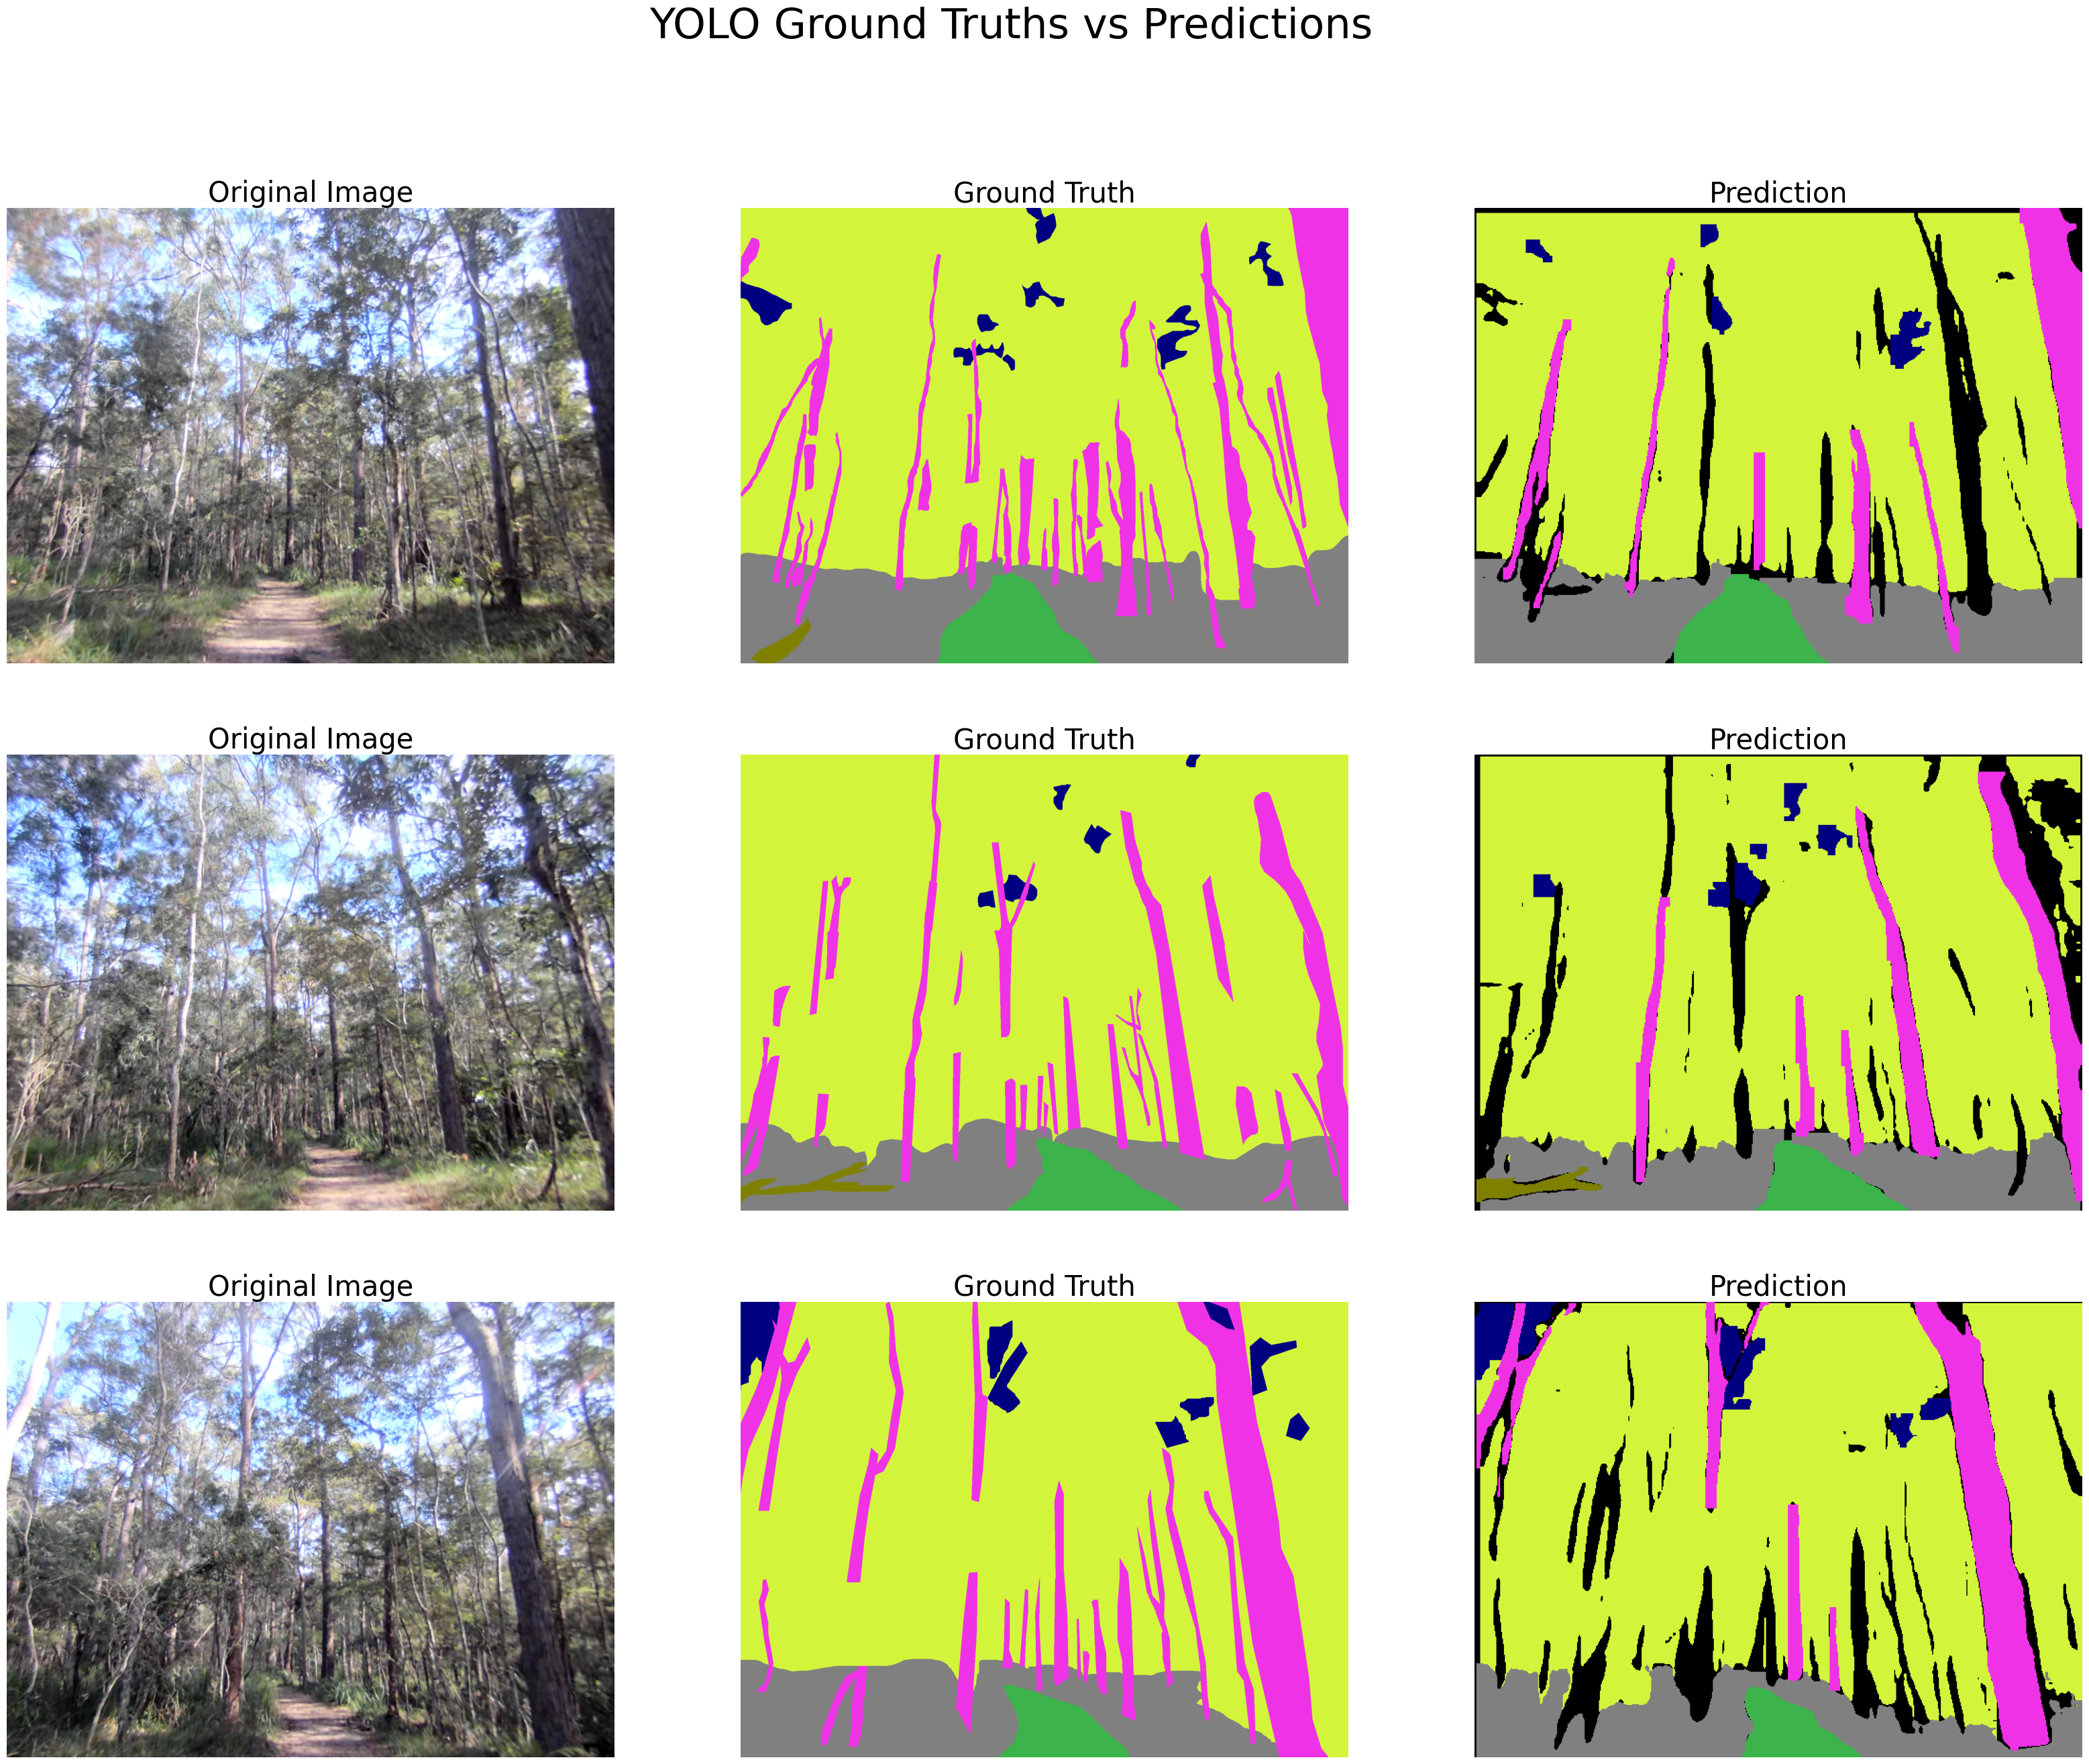

In [14]:
plot_predictions(
    model, test_df, range(3), "YOLO Ground Truths vs Predictions", ensemble=False
)

## 5.2. Ensemble YOLO + U-Net

#### **Model**

In [43]:
class EnsembleYOLO:
    __slots__ = [
        "_yolo",
        "_other",
        "_weight",
    ]

    def __init__(self, yolo, other, weight: float = 1):
        assert not yolo is None and not other is None
        self._yolo = yolo
        self._other = other
        self._weight = weight

    def _set_weight(self, weight: float):
        self._weight = weight

    def _get_img_and_labels(self, df) -> tuple[np.ndarray, np.ndarray]:
        images = np.array(df['im_path']).astype(str)
        labels = np.array(df['label_path']).astype(str)
        return images, labels

    def _get_yolo_predictions(self, inputs, indices=None, rgb=True) -> list[np.ndarray]:
        if indices is None:
            indices = range(len(inputs))
        indices = np.array(indices)
        X_pred = list(inputs[indices])

        results = self._yolo(X_pred)
        _, height, width = results[0].masks.data.cpu().numpy().shape
        semantic_maps = [None] * len(X_pred)

        for i, result in enumerate(results):
            masks  = result.masks.data.cpu().numpy()
            boxes  = result.boxes
            labels = boxes.cls.cpu().numpy()
            semantic_map = np.zeros((height, width), dtype=np.uint8)
        
            for label, mask in zip(labels, masks):
                semantic_map[mask != 0] = label
            if rgb:
                semantic_map = label_to_rgb(semantic_map, METAINFO['palette'])
            semantic_maps[i] = semantic_map
        return semantic_maps

    def _calculate_class_iou(self, y_true, y_pred, num_classes):
        ious = []
        for cls in range(num_classes):
            true_class = (y_true == cls)
            pred_class = (y_pred == cls)
            intersection = np.logical_and(true_class, pred_class).sum()
            union = np.logical_or(true_class, pred_class).sum()
            iou = np.nan if union == 0 else intersection / union
            ious.append(iou)
        return ious

    def _display_iou_score(self, class_ious):
        classes = palette = METAINFO['classes']
        merged_classes = []
        merged_ious = []

        for idx, class_name in enumerate(classes):
            if class_name == "pole":
                # Merge pole IoU into other-object
                other_object_idx = classes.index("other-object")
                class_ious[other_object_idx] += class_ious[idx]
            elif class_name == "asphalt":
                # Merge asphalt IoU into other-terrain
                other_terrain_idx = classes.index("other-terrain")
                class_ious[other_terrain_idx] += class_ious[idx]
            elif class_name not in ["vehicle", "pole", "asphalt", "unlabelled"]:
                merged_classes.append(class_name)
                merged_ious.append(class_ious[idx])

        class_iou_pairs = list(zip(merged_classes, merged_ious))
        sorted_class_iou_pairs = sorted(class_iou_pairs, key=lambda x: x[0])
        print("\nIoU score\n============")
        for class_name, iou in sorted_class_iou_pairs:
            print(f"{class_name}: {iou * 100: .2f}")
        miou = np.nanmean(merged_ious)
        print(f"Mean IoU: {miou * 100: .2f}")

    def display_iou_score(self, test_df):
        test_df = test_df[:2]
        class_ious = self._calculate_class_ious(test_df, IMG_SIZE, NUM_CLASSES)
        self._display_iou_score(class_ious)

    def predict(self, inputs) -> np.ndarray:
        yolo_predictions = self._get_yolo_predictions(inputs, rgb=False)
        unet_predictions = self._get_yolo_predictions(inputs, rgb=False)
        # unet_predictions = get_model_predictions(self._other, inputs)
        for yp, up in zip(yolo_predictions, unet_predictions):
            unlabeled_mask = (yp == 0)
            yp[unlabeled_mask] = up[unlabeled_mask]
        return yolo_predictions

    # Function to calculate IoUs for each class
    def _calculate_class_ious(self, test_df, img_size, num_classes):
        test_gen = data_generator(test_df, 1, img_size, num_classes)
        n = len(test_df)
        y_preds = [None] * n
        y_trues = [None] * n
        for i in range(n):
            test_images, test_labels = next(test_gen)
            y_pred = self.predict(test_images)
            y_preds[i] = y_pred
            y_trues[i] = np.argmax(test_labels, axis=2)

        y_trues = np.concatenate(y_trues, axis=0)
        y_preds = np.concatenate(y_preds, axis=0)
        # y_true_argmax = np.argmax(y_trues, axis=3)
        # y_pred_argmax = np.argmax(y_preds, axis=3)
        class_ious = [None] * num_classes

        for cls in range(num_classes):
            true_class = (y_trues == cls)
            pred_class = (y_preds == cls)
            intersection = np.logical_and(true_class, pred_class).sum()
            union = np.logical_or(true_class, pred_class).sum()
            class_ious[cls] = np.nan if union == 0 else intersection / union
        return class_ious

In [44]:
def to_categorical(y, num_classes):
    return ((y.reshape(-1,1) & (2**np.arange(8))) != 0).astype(int)

def data_generator(df, batch_size, img_size, num_classes):
    while True:
        for start in range(0, len(df), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            for _, row in batch_df.iterrows():
                img = cv2.imread(row['im_path'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size))
                img = img / 255
                
                label = cv2.imread(row['label_path'], cv2.IMREAD_GRAYSCALE)
                label = cv2.resize(label, (img_size, img_size))
                label = to_categorical(label, num_classes)
                
                x_batch.append(img)
                y_batch.append(label)

            yield np.array(x_batch), np.array(y_batch)

#### **Results**

In [45]:
# Import U-Net, or any other model here
model2 = model
ensemble_model = EnsembleYOLO(model, model2)

In [46]:
ensemble_model.display_iou_score(test_df)


0: 640x640 1 tree-foliage, 66.0ms
Speed: 27.2ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 tree-foliage, 69.4ms
Speed: 28.4ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 tree-foliage, 50.9ms
Speed: 24.6ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 tree-foliage, 50.9ms
Speed: 31.0ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ValueError: operands could not be broadcast together with shapes (2,409600) (2,640,640) 